# Metropolitan bicycle sharing system:  How many bicycles need to be ready at a given time
## Regression Approach
Data was taken from https://www.kaggle.com/c/bike-sharing-demand/data in April 2020.       
Plots can be found in the notebook 'bikeSharing_visualPart'

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Initial Data Preprocessing
#### Check size of DataFrames

In [3]:
df.shape

(10886, 11)

#### Check for missing values

In [4]:
df.isnull().values.any()

False

#### Get features out of datetimeindex

In [5]:
df['hour'] = df.index.hour
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofweek'] = df.index.dayofweek

#### First sight on the data (here exemplarily shown on the test data set)
No linear correlation obvious (besides *bike count*). So far, *Linear Regression* does not appear to be the best choice. Even logarithmizing the data (not shown here) does not lead to approximate linear relations.

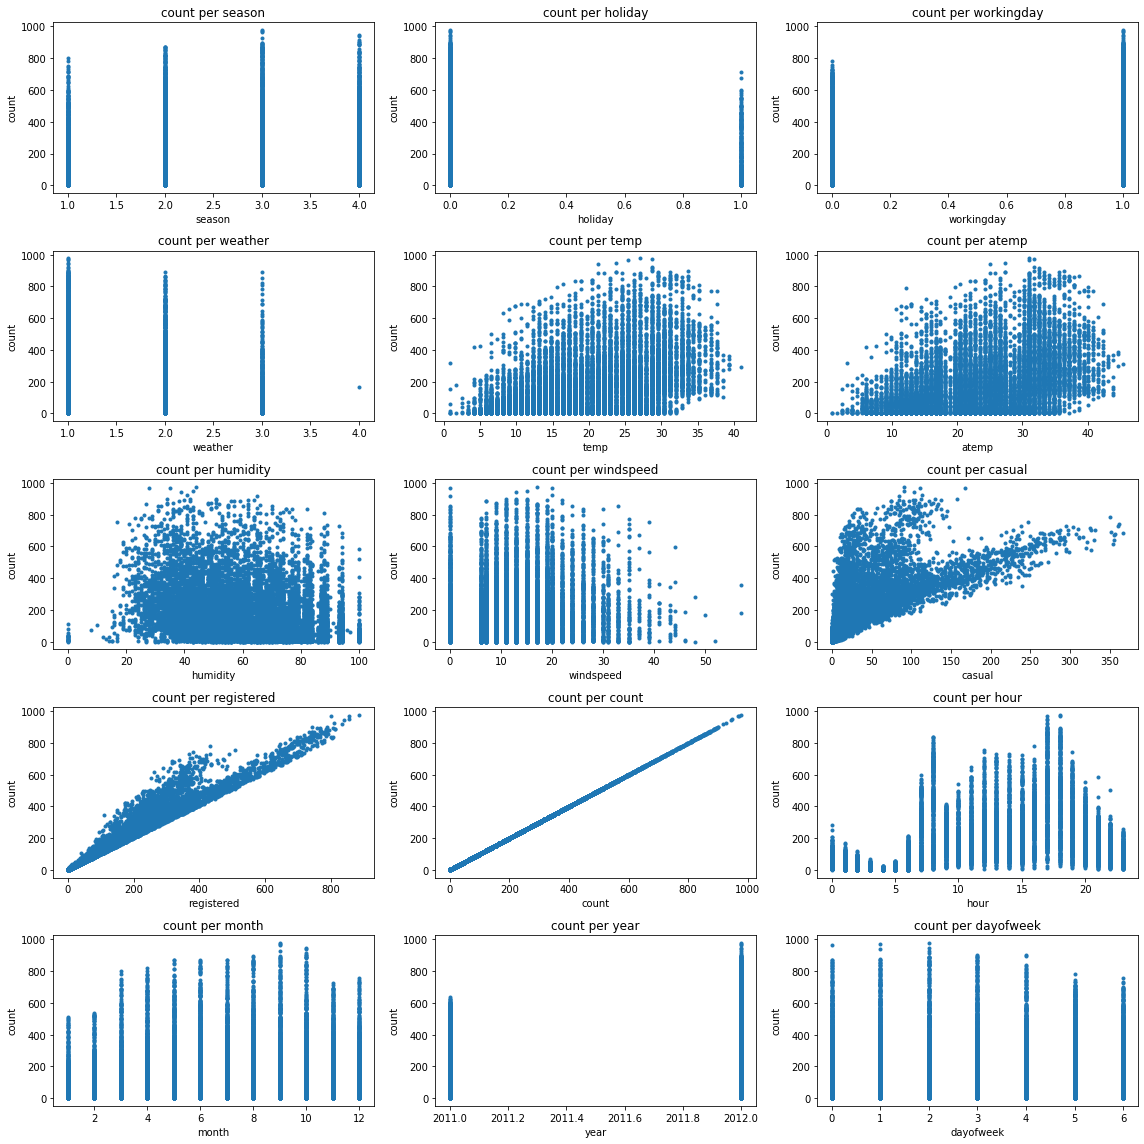

In [6]:
feature_list=list(df.columns)
plt.figure(figsize=(16,16))
for i, elem in enumerate(feature_list,1):
    plt.subplot(5,3,i)
    plt.plot(df[elem], df['count'], '.')
    plt.title('count per ' + str(elem))
    plt.xlabel(elem)
    plt.ylabel('count')
    plt.tight_layout()

#### Distribution Plots (here exemplarily shown on the train data set)
Distributions were not found to be Gaussian.

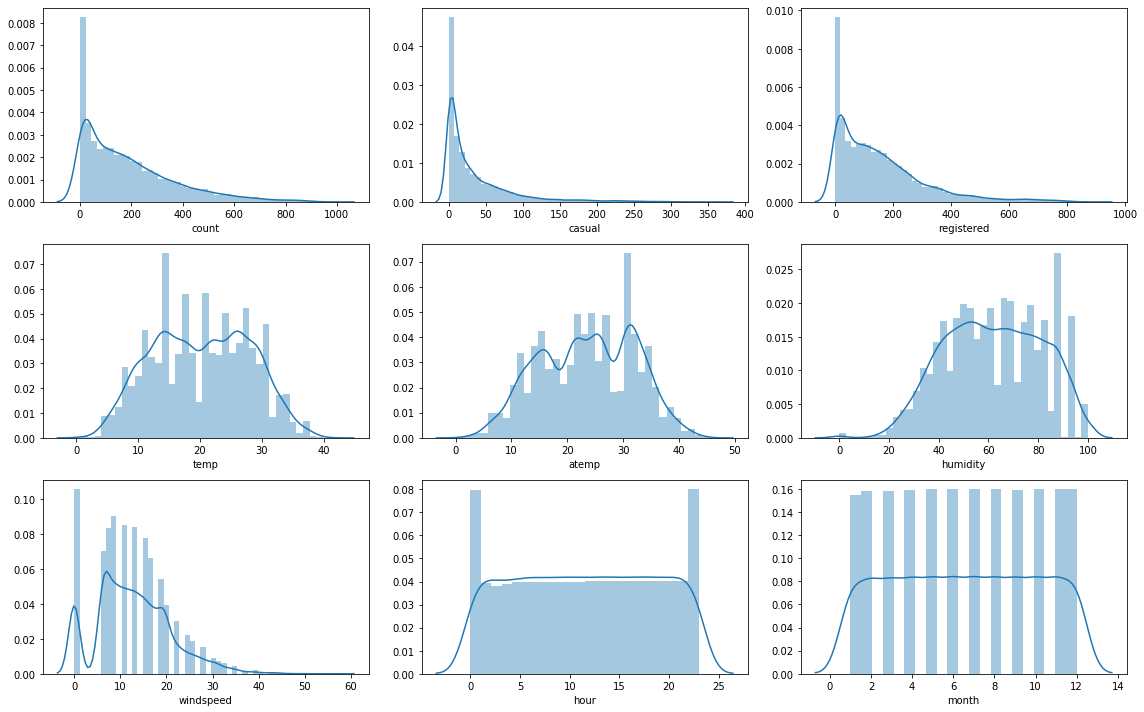

In [7]:
feature_list_dist = ['count', 'casual', 'registered', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'month']
plt.figure(figsize=(16,10))
for i,elem in enumerate(feature_list_dist,1):    
    plt.subplot(3,3,i)
    sns.distplot(df[elem])            
    plt.xlabel(elem)
    plt.tight_layout()

#### Convert data
There is different kind of data (ordinal, binary, interval) which needs to be preprocessed for further analysis: *season* and *dayofweek* need to be one-hot-encoded. To avoid perfect multincollinearity the original ones and one of the newly created (one-hot-encoded) features need to be dropped. In contrast, *year* does not need to be one-hot-encoded as there is data from only two years (*2011* and *2012*) available. However, the years values (*2011* and *2012*) get replaced by *0* and *1* to avoid distortion by the high numbers.

In [8]:
df_season_OHE = pd.get_dummies(df['season'])
df_season_OHE.rename(columns={1:'spring', 2:'summer', 3:'fall', 4:'winter'}, inplace=True)

df_dayofweek = pd.get_dummies(df['dayofweek'])
df_dayofweek.rename(columns={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
                             4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)

df = pd.concat([df, df_season_OHE, df_dayofweek], axis=1)
df = df.drop(['season', 'spring', 'dayofweek', 'Tuesday'], axis=1)

df['year'].replace({2011:0, 2012:1}, inplace=True)
df.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,...,year,summer,fall,winter,Monday,Wednesday,Thursday,Friday,Saturday,Sunday
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,1,9.84,14.395,81,0.0,3,13,16,...,0,0,0,0,0,0,0,0,1,0
2011-01-01 01:00:00,0,0,1,9.02,13.635,80,0.0,8,32,40,...,0,0,0,0,0,0,0,0,1,0
2011-01-01 02:00:00,0,0,1,9.02,13.635,80,0.0,5,27,32,...,0,0,0,0,0,0,0,0,1,0
2011-01-01 03:00:00,0,0,1,9.84,14.395,75,0.0,3,10,13,...,0,0,0,0,0,0,0,0,1,0
2011-01-01 04:00:00,0,0,1,9.84,14.395,75,0.0,0,1,1,...,0,0,0,0,0,0,0,0,1,0


#### Plot correlations in a heatmap

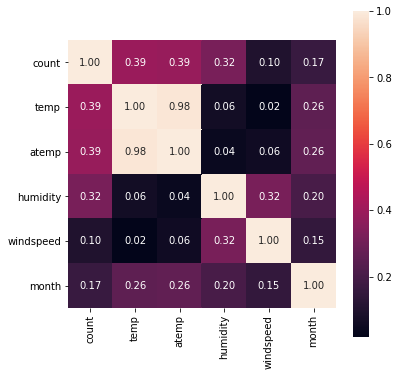

In [9]:
df_heatmap = df[['count', 'temp', 'atemp', 'humidity', 'windspeed', 'month']]
plt.figure(figsize=[6,6])
sns.heatmap(df_heatmap.corr().abs(), annot=True, fmt='.2f', square=True)

In [10]:
df = df.drop(['atemp'], axis=1)

#### Check for multicollinearity using variance inflation factor

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def check_vif(df):
    variables = df[['temp', 'humidity', 'windspeed', 'month']]
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    vif['features'] = variables.columns
    return vif
check_vif(df)

,VIF,features
0,6.373442,temp
1,5.988310,humidity
2,2.709978,windspeed
3,5.117237,month


For a simple linear regression vif values > 5 would not be useful at all. 

#### Check if features *holiday* and *workingday* are mutually exclusive
They are not. There is some overlap between them, so that you should keep both.

In [12]:
(df['holiday']==df['workingday']).value_counts()

False    7723
True     3163
dtype: int64

#### Check if features *registered* and *casual* explain 100% of *count*
Yes, they do

In [13]:
print('registered: '+ str(df[df['registered']!=0].sum()['registered']))
print('casual: '+ str(df[df['casual']!=0].sum()['casual']))
print('registered + casual: ' + str(df[df['registered']!=0].sum()['registered'] + df[df['casual']!=0].sum()['casual']))
print('count: '+ str(df[df['count']!=0].sum()['count']))

registered: 1693341.0
casual: 392135.0
registered + casual: 2085476.0
count: 2085476.0


#### Save DataFrame

In [14]:
df.to_csv('df_preprocessed.csv', index=False)